In [1]:
import pickle, os, torch
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score

In [2]:
folder = 'results_sweep_highz_140122'
pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}')    

In [3]:
runs1=os.listdir(pointer)
runs=[] 
for run in runs1:
    if run[-1]!='3':
        runs.append(run) 
# total of 5 for each z
runs.sort()
runs

['Sage_vlarge_all_4t_z0.5_quantile_raw_dellss',
 'Sage_vlarge_all_4t_z0.5_quantile_raw_nqzrbj',
 'Sage_vlarge_all_4t_z0.5_quantile_raw_uafctu',
 'Sage_vlarge_all_4t_z0.5_quantile_raw_ucbbcd',
 'Sage_vlarge_all_4t_z0.5_quantile_raw_ymibpo',
 'Sage_vlarge_all_4t_z1.0_quantile_raw_asyiqi',
 'Sage_vlarge_all_4t_z1.0_quantile_raw_lvxekh',
 'Sage_vlarge_all_4t_z1.0_quantile_raw_riwufi',
 'Sage_vlarge_all_4t_z1.0_quantile_raw_spvydo',
 'Sage_vlarge_all_4t_z1.0_quantile_raw_trdplp',
 'Sage_vlarge_all_4t_z2.0_quantile_raw_btdjwj',
 'Sage_vlarge_all_4t_z2.0_quantile_raw_fkpccb',
 'Sage_vlarge_all_4t_z2.0_quantile_raw_hnjdfp',
 'Sage_vlarge_all_4t_z2.0_quantile_raw_vrahbz',
 'Sage_vlarge_all_4t_z2.0_quantile_raw_xniyhz']

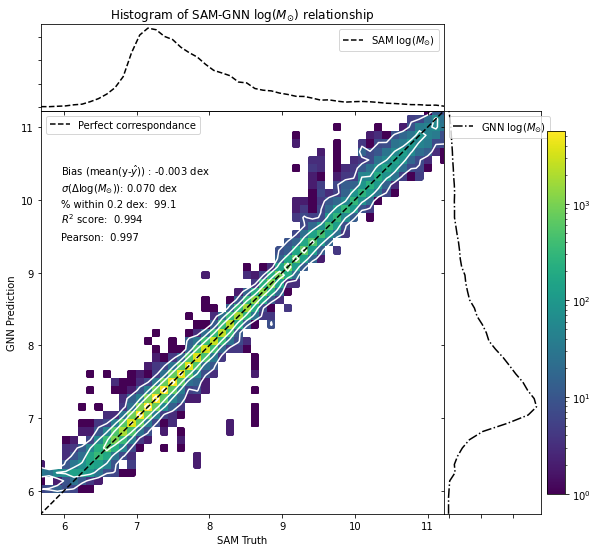

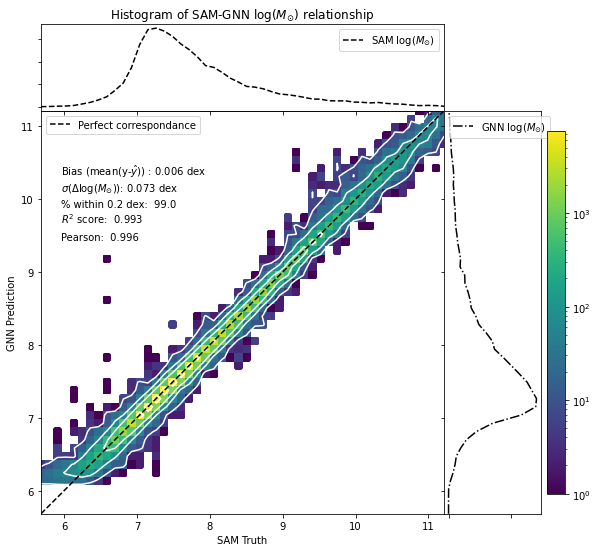

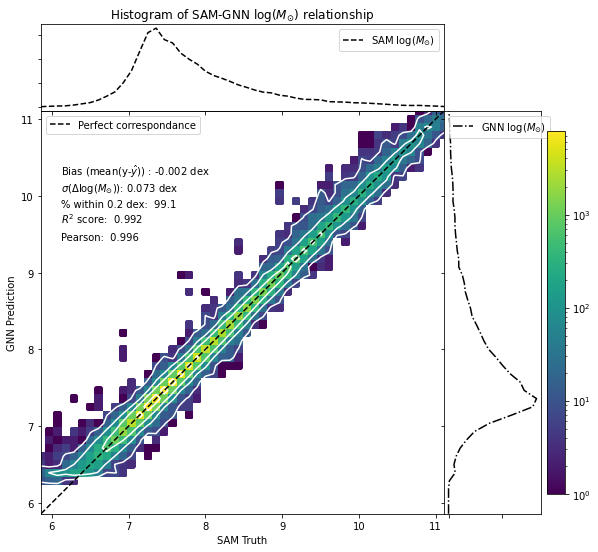

In [4]:
ls =[[0,2,3,4], [5,6,7,8,9], [10,11,12,13,14]]
stds = []
for l in ls:
    yss, preds = [], []
    std=[]
    for k in l:
        results=pickle.load(open(osp.join(pointer,runs[k],'result_dict.pkl'), 'rb'))
        config=pickle.load(open(osp.join(pointer,runs[k],'construct_dict.pkl'), 'rb'))
        ys, pred, targets = results['ys']+9, results['pred']-(results['pred']-results['ys'])/20+9, config["data_params"]['targets']
        yss.append(ys)
        preds.append(pred)
        std.append(np.std(ys-pred))
    stds.append(np.array(std))
    ys=np.vstack(yss)
    pred=np.vstack(preds)
    from matplotlib.ticker import NullFormatter
    from scipy import stats

    n=0
    target=r"log($M_{\odot}$)"
    # target=r"$v_{disk}$"

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.7
    bottom, height = 0.1, 0.7
    bottom_h = left_h = left + width
    # rect_Cbar = [0, bottom, 0.1, height]
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.15]
    rect_histy = [left_h, bottom, 0.15+0.06, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))
    # axCbar = plt.axes(rect_Cbar)
    axHist = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    axHistx.yaxis.set_major_formatter(nullfmt)
    axHisty.xaxis.set_major_formatter(nullfmt)

    bins=50
    l=0.01
    xt=0.05
    yt=0.8
    n_contour=4
    # the scatter plot:
    vals, x, y, hist =axHist.hist2d( ys[:,n], pred[:,n],bins=bins, range=[np.percentile(np.hstack([ys[:,n],pred[:,n]]), [0+l,100-l]),
                                np.percentile(np.hstack([ys[:,n],pred[:,n]]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
    X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
    axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white')
    axHist.plot([min(ys[:,n]),max(ys[:,n])],[min(ys[:,n]),max(ys[:,n])], 'k--', label='Perfect correspondance')
    axHist.set(xlabel='SAM Truth',ylabel='GNN Prediction')
    axHist.legend()

    # now determine nice limits by hand:
    X, Y = X[0], Y.T[0]
    axHist.set_xlim((min(X), max(X)))
    axHist.set_ylim((min(Y), max(Y)))
    yhat=r'$\hat{y}$'
    pct=np.sum((ys[:,n]-pred[:,n])<0.2)/len(ys[:,n]-pred[:,n])

    r2=r2_score(ys[:,n],pred[:,n])
    rho = np.corrcoef(ys[:,n],pred[:,n])[0,1]
    axHist.text(xt,yt+0.04, f'Bias (mean(y-{yhat})) : {np.mean(ys[:,n]-pred[:,n]):.3f} dex', transform=axHist.transAxes)
    axHist.text(xt,yt, r'$\sigma$'+f'($\Delta${target}): '+f'{np.std(ys[:,n]-pred[:,n]):.3f} dex', transform=axHist.transAxes)
    axHist.text(xt,yt-0.04, '% within 0.2 dex:  '+f'{pct*100:.1f}', transform=axHist.transAxes)
    axHist.text(xt,yt-0.08, r'$R^2$ score:  '+f'{r2:.3f}', transform=axHist.transAxes)
    axHist.text(xt,yt-0.12, r'Pearson:  '+f'{rho:.3f}', transform=axHist.transAxes)



    # axHistx.hist(ys[:,n], bins=bins, histtype='step', density=1)
    # axy=axHisty.hist(pred[:,n], bins=bins, histtype='step', density=1, orientation='horizontal')
    ys_kde = stats.gaussian_kde(ys[:,n], 0.05)
    pred_kde = stats.gaussian_kde(pred[:,n], 0.05)
    axHistx.plot(X, ys_kde(X), 'k--', label=f'SAM {target}')
    axHisty.plot(pred_kde(Y), Y, "k-.", label=f'GNN {target}')
    axHistx.legend()
    axHisty.legend(loc='upper left')

    axHistx.set(title=f'Histogram of SAM-GNN {target} relationship')

    axHistx.set_xlim(axHist.get_xlim())
    axHisty.set_ylim(axHist.get_ylim())

    plt.colorbar(hist, ax=axHisty, location='right')

    plt.show()

In [5]:
stds = np.array(stds)
errs = np.array([np.std(stds[0]), np.std(stds[0]), np.std(stds[1]), np.std(stds[2])])
mus = np.array([0.082, np.mean(stds[0]), np.mean(stds[1]), np.mean(stds[2])])
zs = [0, 0.5,1,2]

/tmp/ipykernel_17681/3594240967.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stds = np.array(stds)


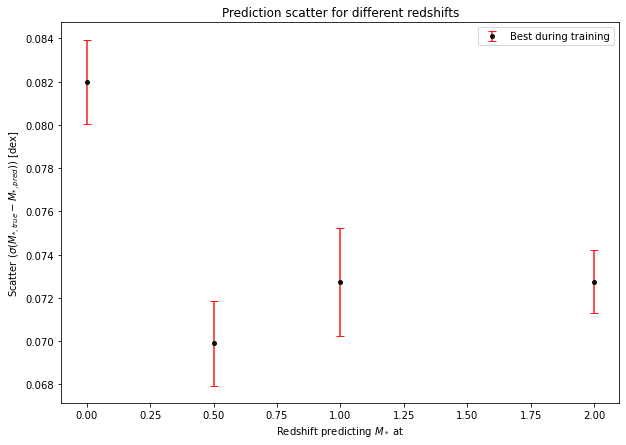

In [6]:
fig, ax =plt.subplots(figsize=(10,7))
ax.errorbar(zs, mus, yerr=errs, color='k', fmt='.', markersize=8,
            capsize=4, ecolor='r', alpha=0.9, label='Best during training')
# ax.plot(percentiles+0.5, ml, 'k--', alpha=0.4)
ax.set(xlabel=r'Redshift predicting $M_*$ at', ylabel=r'Scatter ($\sigma (M_{*,true}-M_{*,pred})$) [dex]')
ax.set(title='Prediction scatter for different redshifts')
ax.legend()

In [7]:
errs, mus

(array([0.00194627, 0.00194627, 0.00250013, 0.00145816], dtype=float32),
 array([0.082     , 0.06989912, 0.07275081, 0.07275824]))